# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd

from text_classification import defs

Get source assets.

In [2]:
train_df: pd.DataFrame = pd.DataFrame(defs.load_asset_value("source_train"))  # type: ignore
test_df: pd.DataFrame = pd.DataFrame(defs.load_asset_value("source_test"))  # type: ignore

2023-02-12 23:31:48 +0000 - dagster - DEBUG - system - Loading file from: /Users/thomelane/Projects/text_classification/data/storage/source_train
2023-02-12 23:31:48 +0000 - dagster - DEBUG - system - Loading file from: /Users/thomelane/Projects/text_classification/data/storage/source_test


## Samples

In [3]:
print(f"Samples in train_df: {len(train_df):,}")
print(f"Samples in test_df: {len(test_df):,}")

Samples in train_df: 65,000
Samples in test_df: 34,171


🧠 ~65% of samples in training set.

In [4]:
def print_row(row: pd.Series):
    print("#" * 50)
    fields = [str(f) for f in row.index]
    for field in fields:
        print(f"# {field}:")
        print(str(row[field]) + "\n")
        
        
def print_sample_rows(df: pd.DataFrame, n: int = 10):
    df.sample(n=n).apply(print_row, axis=1)  # type: ignore

In [5]:
print_sample_rows(train_df)

##################################################
# authors:
Sarah Barness

# category:
I

# headline:
Little Girl Saves Capsized Boat With Her Crazy Legs

# link:
https://www.huffingtonpost.com/entry/bajau-laut-girl-capsized-boat-legs_n_5461091.html

# short_description:


##################################################
# authors:
Mandy Velez

# category:
J

# headline:
Henry Hallum, 4-Year-Old Cancer Patient, Gets Over 700 Birthday Cards On His Special Day

# link:
https://www.huffingtonpost.com/entry/henry-hallum_us_5b9d8082e4b03a1dcc88d56d

# short_description:
They've raised £104,000 (about $164,580) so far, but will continue to accept donations in order to reach their £500,000 ($785,950.00

##################################################
# authors:
Dana Oliver

# category:
F

# headline:
Anna Dello Russo Wigs Out For Radio Deejay's 30th Anniversary (PHOTO, POLL)

# link:
https://www.huffingtonpost.com/entry/anna-dello-russo-hair_us_5b9b45a8e4b03a1dcc762c57

# short_descrip

🚨 Seeing some missing data (for author and short_description).

💪 Will want to check missing data ratios at some point.

🧠 Some structure and metadata included in the text fields. e.g.

`(PHOTOS)`, `Lee Daniels: I Wouldn't Be Where I Am If I Embraced Racism`

🧠 Could be information in `author` field that we'd be ignoring if we skipped
the feature. e.g.

```
Debbe Daley, Contributor
Principal and owner at Debbe Daley Designs LLC
```

🧠 Even without headline or description, we could guess the article would be
about design.

🧠 Concern with `author` field was authors would write multiple articles in
the same category, and a model would just learn this mapping, rather than
learning from the article headlines and short_description. We could
mask/remove the name and leave the rest, but it's only a partial solution and
more complex.

⭐️ Check hypothesis that authors post multiple time (and in same category).

## Classes

❓ How many classes (or categories) are we dealing with?

In [6]:
classes_in_train = set(train_df["category"].unique())
print(f"Classes in train_df: {len(classes_in_train)}")

Classes in train_df: 10


In [7]:
classes_in_test = set(test_df["category"].unique())
print(f"Classes in test_df: {len(classes_in_test)}")

Classes in test_df: 10


❓ Are they the same classes? Or are there new ones (or subset)
in the test set?

In [8]:
assert len(classes_in_train.difference(classes_in_test)) == 0
assert len(classes_in_test.difference(classes_in_train)) == 0

Yes, they are the same classes.

❓ What's the count for each class? Is it a 'balanced' problem?

In [9]:
def plot_class_counts(df: pd.DataFrame) -> None:
    class_counts = df["category"].value_counts(normalize=True)
    class_counts.sort_index().plot(kind="bar")

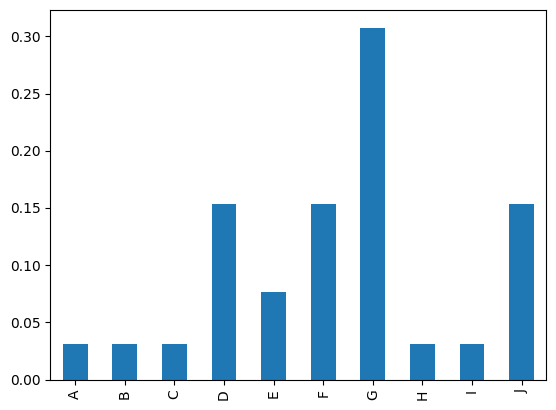

In [10]:
plot_class_counts(train_df)

🚨 It's imbalanced. As expected from the dataset summary page on
Kaggle.

❓ Is there any difference in class distribution at test/inference time?

🧠 Would like to assume that test set is representative of inference requests,
but still want to check a few things there.

In [11]:
def plot_class_counts_comparision(
    df_1: pd.DataFrame,
    label_1: str,
    df_2: pd.DataFrame,
    label_2: str,
) -> None:
    class_counts_1 = df_1["category"].value_counts(normalize=True)
    class_counts_2 = df_2["category"].value_counts(normalize=True)
    class_counts = pd.concat([
        class_counts_1.rename(label_1),
        class_counts_2.rename(label_2)
    ], axis=1)
    class_counts.sort_index().plot(kind="bar")

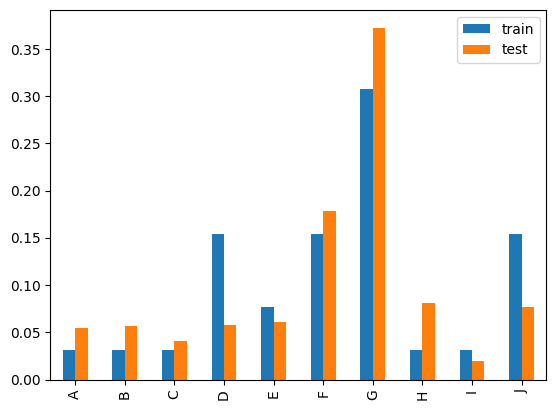

In [12]:
plot_class_counts_comparision(train_df, "train", test_df, "test")

🧠 Some differences here, but nothing major (e.g. majority class
at test time being minority class in training set).

🧠 We can also see that the class labels are just alphabetical. We don't get
additional information as to what the classes represent. If we had class
labels like "Politics", "Sport", etc. we could have possibly used this
information to bootstrap a simple baseline model (e.g. use word embedding of
the class label). But we can't.

## Missing Data

❓ What are the missing data proportions for each field?

In [13]:
train_df.isna().mean()

authors              0.0
category             0.0
headline             0.0
link                 0.0
short_description    0.0
dtype: float64

🧠 No missing data?!

🧠 Seems suspect given we've seen it. Will likely be due to whitespace being
counted as not na. Will convert.

In [14]:
def blank_to_na(string: str):
    string = string.strip()
    if len(string) == 0:
        return pd.NA
    else:
        return string

In [15]:
train_df = train_df.applymap(blank_to_na)
test_df = test_df.applymap(blank_to_na)

🧠 Will want to apply this clean up during training and
inference.

In [16]:
train_df.isna().mean()

authors              0.196846
category             0.000000
headline             0.000046
link                 0.000000
short_description    0.087123
dtype: float64

🧠 ~20% of time the `author` field is missing. Another reason to
skip this field for first version.

🚨 Also ~8% for `short_description` field, which we had noted as one of the
most important fields.

👍 Good to see that category is never missing. And headline very rarely.

💪 Will look at missing overlap between `headline` and `short_description`

⭐️ Would look at full cross plot of missing values with more time.

In [17]:
train_df.isna()[["headline", "short_description"]].all(axis=1).sum()

3

🧠 Only 3 samples out of 65,000 have a missing `headline` and
`short_description`.

🧠 A negligible amount, but it's still an edge case to handle.

🧠 Should we introduce an "Unknown" class? e.g. with class index of `-1`?

💡 Could also apply to case where model isn't confident about top predicted
class.

## Character Length

❓ What's the distribution of character length of `headline` and
`short_description`.

🧠 Also interested in token length, but we haven't decided on a model (and
tokenizer) yet.

In [18]:
train_df["headline_length"] = train_df["headline"].str.len().fillna(0)
train_df["headline_length"].describe()

count    65000.000000
mean        60.295046
std         18.777176
min          0.000000
25%         48.000000
50%         62.000000
75%         73.000000
max        320.000000
Name: headline_length, dtype: float64

🧠 Will be easier to visualize this.

<AxesSubplot: ylabel='Frequency'>

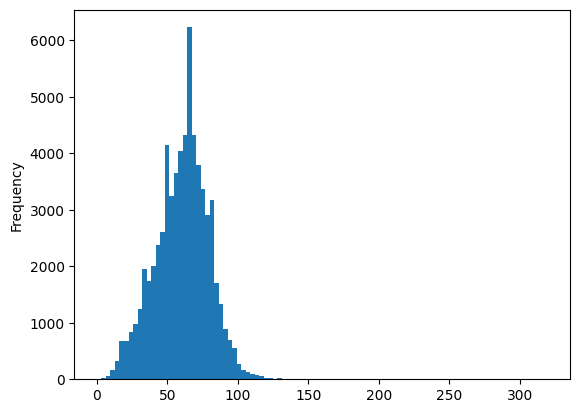

In [19]:
train_df["headline_length"].plot(kind="hist", bins=100)

🧠 Max of 320 is quite an outlier. It doesn't seem to be a
trimmed distribution.

❓ What are the spikes?

In [20]:
train_df["headline_length"].value_counts().head(10)

65    1632
67    1553
66    1525
64    1521
70    1464
63    1453
62    1446
61    1432
68    1428
69    1426
Name: headline_length, dtype: int64

🧠 It's not a single value.

❓ What are some samples for these cases?

In [21]:
print_sample_rows(train_df.query("headline_length == 120"), n=3)

##################################################
# authors:
Andrew H. Nichols, ContributorDirector of Higher Education Research and Data Analytics

# category:
D

# headline:
Standing Up For And Supporting Latinx Students On America’s College Campuses: Lessons From Hispanic-Serving Institutions

# link:
https://www.huffingtonpost.com/entry/standing-up-for-and-supporting-latinx-students-on-americas_us_59cbd34de4b0b99ee4a9c9b2

# short_description:
There's a difference between "Hispanic-serving" and just "Hispanic-enrolling."

# headline_length:
120

##################################################
# authors:
Geoffrey R. Stone, ContributorEdward H. Levi Distinguished Service Professor of Law, The Uni...

# category:
G

# headline:
Trump's Outrageous 'Proclamation' About Transgender Persons Serving In The Military Is Ignorant, Immoral And Un-American

# link:
https://www.huffingtonpost.com/entry/trumps-outrageous-proclamation-about-transgender_us_59793fb8e4b0c69ef7052588

# short_desc

🧠 Can't see anything obviously wrong here. Could just be an
advisory character count in th UI.

❓ What about `short_description`?

In [22]:
train_df["short_description_length"] = train_df["short_description"].str.len().fillna(0)
train_df["short_description_length"].describe()

count    65000.000000
mean       111.765123
std         79.123164
min          0.000000
25%         62.000000
50%        120.000000
75%        126.000000
max       1472.000000
Name: short_description_length, dtype: float64

<AxesSubplot: ylabel='Frequency'>

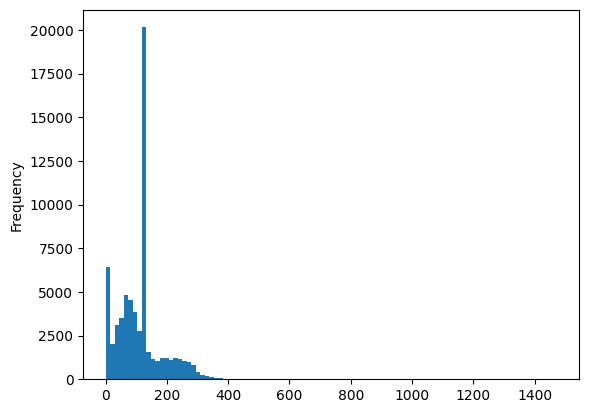

In [23]:
train_df["short_description_length"].plot(kind="hist", bins=100)

🧠 Similar, but even more pronounced spikes.

❓ What are these spikes?

In [24]:
train_df["short_description_length"].value_counts().head(10)

0      5663
121    3233
120    3212
122    3093
123    2788
124    2155
125    1634
126    1258
127     837
128     529
Name: short_description_length, dtype: int64

🧠 0 is known, because it's the missing values we've seen
earlier.

🧠 Otherwise quite a few around samples with `short_description_length` of
>=120.

❓ What do these samples look like?

In [25]:
print_sample_rows(train_df.query("short_description_length == 120"), n=3)

##################################################
# authors:
<NA>

# category:
J

# headline:
10 Tips For A Better Labor Day

# link:
https://www.huffingtonpost.comhttp://www.fitpregnancy.com/labor-delivery/labor-delivery/10-tips-better-labor-day

# short_description:
It often feels like life is moving faster and faster all the time, but in the delivery room, things are actually slowing

# headline_length:
30

# short_description_length:
120

##################################################
# authors:
<NA>

# category:
J

# headline:
20 Mouthwatering (and Healthy!) After-School Snacks That Won't Spoil Dinner

# link:
https://www.huffingtonpost.comhttp://moms.popsugar.com/Best-After-School-Snacks-31433356

# short_description:
Typical scene: your kids have just finished up a busy day at school, and now they're ravenous. The trick is to give them

# headline_length:
75

# short_description_length:
120

##################################################
# authors:
<NA>

# category:
E



🚨 It looks like there's been trimming applied here.

```
For advertisers, Christmas is a way to get people to buy by doing whatever it takes. One German company, Edeka, goes all
```

🧠 Although slightly strange that it's at a variety of different character
lengths.

💡 Could be quite a good data augmentation strategy.

❓ Should these cases be removed from the dataset.

🧠 We ultimately want to optimize robust validation metrics, so the question
is whether we want them removed from that set.

❓ Are these cases more common for a certain class?

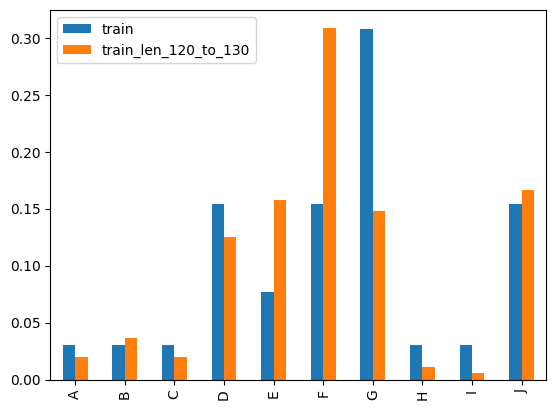

In [26]:
plot_class_counts_comparision(
    train_df,
    "train",
    train_df.query("short_description_length >= 120 & short_description_length < 130"),
    "train_len_120_to_130"
)

🧠 Yes, but still happens for all classes.

❓ Are these cases in the test set too?

<AxesSubplot: ylabel='Frequency'>

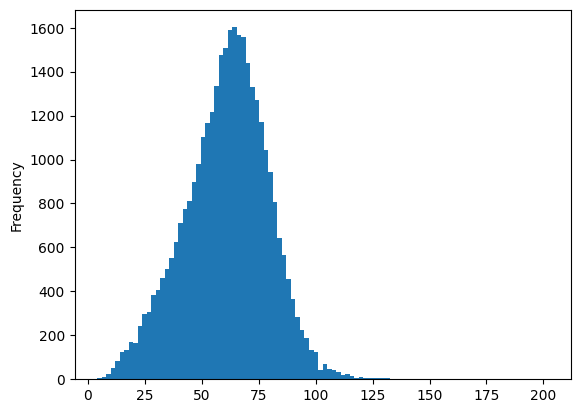

In [27]:
test_df["headline_length"] = test_df["headline"].str.len().fillna(0)
test_df["headline_length"].plot(kind="hist", bins=100)

🧠 Smoother distribution for test set here. Small drop just
after 100, but not too concerning.

<AxesSubplot: ylabel='Frequency'>

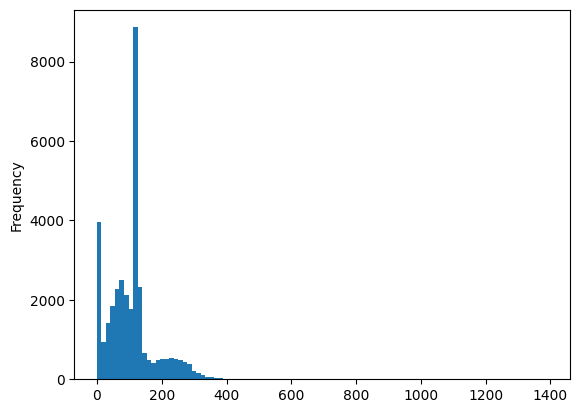

In [28]:
test_df["short_description_length"] = test_df["short_description"].str.len().fillna(0)
test_df["short_description_length"].plot(kind="hist", bins=100)

🧠 Get spikes for `short_description_length` in test set too.

🧠 Gives more confidence that train and test are samples from the same
distribution.

🧠 Going to assume that we'll get these cases at inference time too.

🪨 Will leave these cases in the dataset (all splits).

💪 If time permits, and improvements are needed, will try trimming as a data
augmentation strategy during training.

## Over time

❓ What's the distribution of samples over time between train and
test?

In [29]:
print(train_df.columns)

Index(['authors', 'category', 'headline', 'link', 'short_description',
       'headline_length', 'short_description_length'],
      dtype='object')


🧠 Where is the field for date? Assume it's been removed from
original data source.

🚨 Will assume the samples have been split by time, but can't verify this.

🚨 In a real world assignment, I would like to have full knowledge/control of
splitting process. A very common source of error.